In [40]:
!pip install tensorflow

In [41]:
import os
import pickle
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package stopwords to C:\Users\Arnesh
[nltk_data]     Bhattacharjee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Arnesh
[nltk_data]     Bhattacharjee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
# sklearn for preprocessing and machine learning models
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics  import accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras for neural networks
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics  import accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [45]:
raw_df = pd.read_csv('Tweets.csv')

In [46]:
raw_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [47]:
raw_df.shape

(14640, 15)

In [48]:
raw_df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

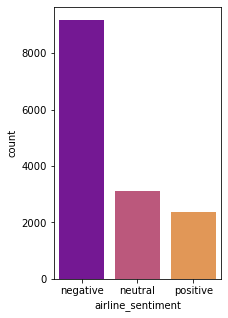

In [78]:
import seaborn as sns
plt.figure(figsize=(3,5))
sns.countplot(raw_df['airline_sentiment'], order =raw_df.airline_sentiment.value_counts().index,palette= 'plasma')
plt.show()

In [81]:
g = sns.FacetGrid(raw_df, col=”airline”, col_wrap=3, height=5, aspect =0.7) g = g.map(sns.countplot, “airline_sentiment”,order =raw_df[airline_sentiment].value_counts().index, palette=’plasma’) plt.show()

SyntaxError: invalid character in identifier (<ipython-input-81-f2938b92463f>, line 1)

In [49]:
raw_df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [50]:
df = raw_df[['text', 'airline_sentiment']]

In [51]:
df.shape

(14640, 2)

In [52]:
df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [53]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [54]:
seed = 1234
np.random.seed(seed)
tensorflow.random.set_seed(seed)

In [55]:
class PreProcessor:
    '''
    Easily performs all the standard preprocessing steps
    like removing stopwords, stemming, etc.
    Only input that you need to provide is the dataframe and column name for the tweets
    '''
    def __init__(self, df, column_name):
        self.data = df
        self.conversations = list(self.data[column_name])
        self.stopwords = set(stopwords.words('english'))
        self.stemmer = SnowballStemmer("english")
        self.preprocessed = []

    def tokenize(self, sentence):
        '''
        Splits up words and makes a list of all words in the tweet
        '''
        tokenized_sentence = word_tokenize(sentence)
        return tokenized_sentence

    def remove_stopwords(self, sentence):
        '''Removes stopwords like 'a', 'the', 'and', etc.'''
        filtered_sentence = []
        for w in sentence:
            if w not in self.stopwords and len(w) > 1 and w[:2] != '//' and w != 'https':
                filtered_sentence.append(w)
        return filtered_sentence

    def stem(self, sentence):
        '''
        Stems certain words to their root form.
        For example, words like 'computer', 'computation'
        all get truncated to 'comput'
        '''
        return [self.stemmer.stem(word) for word in sentence]

    def join_to_string(self, sentence):
        '''
        Joins the tokenized words to one string.
        '''
        return ' '.join(sentence)

    def full_preprocess(self, n_rows=None):
        '''
        Preprocess a selected number of rows and
        connects them back to strings
        '''
        # If nothing is given do it for the whole dataset
        if n_rows == None:
            n_rows = len(self.data)

        # Perform preprocessing
        for i in range(n_rows):
            tweet = self.conversations[i]
            tokenized = self.tokenize(tweet)
            cleaned = self.remove_stopwords(tokenized)
            stemmed = self.stem(cleaned)
            joined = self.join_to_string(stemmed)
            self.preprocessed.append(joined)
        return self.preprocessed
    
    def strip_html(text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    
    def remove_numbers(text):
       text = re.sub(r'\d+', '', text)
       return text


In [57]:
from nltk.stem.wordnet import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

In [58]:
preprocessor = PreProcessor(df, 'text')
df['cleaned_text'] = preprocessor.full_preprocess()
df = shuffle(df, random_state=seed)
# Create test set
test_set = df[:1000]

# Create train and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['cleaned_text'][1000:],
                                                      df['airline_sentiment'][1000:],
                                                      test_size=0.2,
                                                      random_state=seed)

# Get sentiment labels for test set
y_test = test_set['airline_sentiment']

<ipython-input-58-10529ad9f6ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = preprocessor.full_preprocess()


In [59]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(test_set['cleaned_text'])

In [60]:
# Generator so we can easily feed batches of data to the neural network
def batch_generator(X, y, batch_size, shuffle):
    number_of_batches = X.shape[0]/batch_size
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

# Onehot encoding of target variable
# Negative = [1,0,0], Neutral = [0,1,0], Positive = [0,0,1]

# Initialize sklearn's one-hot encoder class
onehot_encoder = OneHotEncoder(sparse=False)

# One hot encoding for training set
integer_encoded_train = np.array(y_train).reshape(len(y_train), 1)
onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)

# One hot encoding for validation set
integer_encoded_val = np.array(y_val).reshape(len(y_val), 1)
onehot_encoded_val = onehot_encoder.fit_transform(integer_encoded_val)

# Neural network architecture
initializer = tensorflow.keras.initializers.he_normal(seed=seed)
activation = tensorflow.keras.activations.elu
optimizer = tensorflow.keras.optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=4)

# Build model architecture
model = Sequential()
model.add(Dense(20, activation=activation, kernel_initializer=initializer, input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax', kernel_initializer=initializer))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [61]:
# Hyperparameters
epochs = 15
batch_size = 16

# Fit the model using the batch_generator
hist = model.fit_generator(generator=batch_generator(X_train, onehot_encoded_train, batch_size=batch_size, shuffle=True),
                           epochs=epochs, validation_data=(X_val, onehot_encoded_val),
                           steps_per_epoch=X_train.shape[0]/batch_size, callbacks=[es])

C:\Users\Arnesh Bhattacharjee\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
680/682 [============================>.] - ETA: 0s - loss: 0.6389 - accuracy: 0.5860

InvalidArgumentError: indices[1] = [0,7387] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse]

In [71]:

import re                                     
from bs4 import BeautifulSoup                           # Import BeautifulSoup.
nltk.download('wordnet')
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.


[nltk_data] Downloading package wordnet to C:\Users\Arnesh
[nltk_data]     Bhattacharjee\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


In [72]:
from nltk.stem import PorterStemmer                 # Stemmer
from nltk.tokenize import word_tokenize 


from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words

!pip install vaderSentiment

In [73]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)                # Keep only 1000 features as number of features will increase the processing time.
data_features = vectorizer.fit_transform(df['text'])

data_features = data_features.toarray() 

In [74]:
df.head

<bound method NDFrame.head of                                                     text airline_sentiment  \
11135  @USAirways we bought our tickets months ago. H...          negative   
3783   @united why is my flight from mke to ord getti...          negative   
13332  @AmericanAir My boyfriend was supposed to be h...          negative   
11639                @USAirways sits on a throne of lies          negative   
4496   @SouthwestAir it's just the principle - it's h...          negative   
...                                                  ...               ...   
11468  @USAirways why would a flight arrive Late Flig...          negative   
7221   @JetBlue I tried! Had me running from curb-sid...          negative   
1318   @united Stopped flying @united 1 yr ago bc of ...          negative   
8915   @JetBlue's new CEO seeks the right balance to ...           neutral   
11055          @USAirways we got our bags today. Thanks!           neutral   

                                 

In [86]:
# alt. method
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

ModuleNotFoundError: No module named 'lightgbm'

In [87]:
twitter_sentiment = Pipeline([('CVec', CountVectorizer(CountVectorizer(stop_words='english'))),
                     ('Tfidf', TfidfTransformer()),
                      ('norm', Normalizer()),Z"
                    ('tSVD', TruncatedSVD(n_components=100)),
                     ('lgb', LGBMClassifier(n_jobs=-1))])

SyntaxError: EOL while scanning string literal (<ipython-input-87-0a2a836ff1c4>, line 3)

After running our optimization, it is straightforward to select the hyperparameter configuration that yielded the highest accuracy, lowest loss, or whatever performance you were seeking to optimize. Here we keep the optimization problem rather simple: we only search epoch, batch_size, and dropout. Select the neural net architecture for now and fine tune it. Note if we decide we'd like to revisit those architectures in the future, all we'll have to do is view those and we'll be able to reproduce them.